# Generate prediction by VARMA

In [22]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR,VARResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.tsa.stattools as st

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Show result of ADF inspection

In [23]:
def testStationarity(Frame):
	for ColumnsName in list(Frame):
		print("Name of variable:"+ ColumnsName)
		dftest = st.adfuller(Frame[ColumnsName])
		# describe result of adfuller function
		dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
		for key,value in dftest[4].items():
			dfoutput['Critical Value (%s)'%key] = value
		print(dfoutput)
		print("\n")

Import data and select 1,3,4 columns as predict data

In [24]:
df = pd.read_excel("AirQualityUCI.xlsx",parse_dates=[['Date', 'Time']])
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time
NewFrame = pd.DataFrame(data,columns=['CO(GT)','PT08.S1(CO)','C6H6(GT)'])

Using average of the numbers before and after to replace -200 (Vacancy value)

In [25]:
for row in list(NewFrame):
    for index,row_d in df.iterrows():
        if(NewFrame[row][index] == -200):
            m=1
            while(NewFrame[row][index+m] == -200):
                m+=1
            NewFrame[row][index] = (NewFrame[row][index-1]+NewFrame[row][index+m])/2

In [26]:
NewFrame = NewFrame.loc['2004-03-10 20:00:00':'2004-03-20 20:00:00']
testStationarity(NewFrame)

Name of variable:CO(GT)
Test Statistic                -7.029634e+00
p-value                        6.233598e-10
#Lags Used                     5.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


Name of variable:PT08.S1(CO)
Test Statistic                -6.108749e+00
p-value                        9.444456e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


Name of variable:C6H6(GT)
Test Statistic                -6.512591e+00
p-value                        1.091023e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critica

Data here is stable but we still do first order difference, after this p-values turn to 0

In [31]:
first = NewFrame.loc['2004-03-10 20:00:00']#For Reduction sequence
diff_1_list = NewFrame.diff(1)
diff_1_list.dropna(inplace=True)
testStationarity(diff_1_list)

Name of variable:CO(GT)
Test Statistic                -7.779623e+00
p-value                        8.485740e-12
#Lags Used                     1.000000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


Name of variable:PT08.S1(CO)
Test Statistic                -8.495425e+00
p-value                        1.279773e-13
#Lags Used                     8.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


Name of variable:C6H6(GT)
Test Statistic                -8.610544e+00
p-value                        6.493778e-14
#Lags Used                     7.000000e+00
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critica

#Code below used to determine the parameter p,q  
#arma_order_select_ic used here to give every variable's best p,q
#Result: 
#C6H6(GT)-> 'bic_min_order': (1, 2), 'aic_min_order': (4, 4), 'hqic_min_order': (4, 4)
#CO(GT)->'bic_min_order': (4, 4), 'aic_min_order': (4, 4), 'hqic_min_order': (4, 4)
#PT08.S1(CO)->'bic_min_order': (4, 3), 'aic_min_order': (4, 3), 'hqic_min_order': (4, 3)

In [17]:
# order = st.arma_order_select_ic(diff_1_list['PT08.S1(CO)'],max_ar = 5,max_ma = 4,ic = ['bic','aic','hqic'])

Generate prediction by VARMA

In [32]:
model = VARMAX(endog = diff_1_list, order=(4,4))
res = model.fit(maxiter=1000, disp=False)       

D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[sl

In [41]:
prediction = res.predict(strat = 0,end = 239)
#Due to the original sequence length is 240，end should be 239
#here if you want forecast future sequence,rmse can not be compute 

In [42]:
print(NewFrame)
print(diff_1_list)
print(prediction)

                     CO(GT)  PT08.S1(CO)   C6H6(GT)
Date_Time                                          
2004-03-10 20:00:00     2.2      1402.00   8.997817
2004-03-10 21:00:00     2.2      1375.50   9.228796
2004-03-10 22:00:00     1.6      1272.25   6.518224
2004-03-10 23:00:00     1.2      1197.00   4.741012
2004-03-11 00:00:00     1.2      1185.00   3.624399
...                     ...          ...        ...
2004-03-20 16:00:00     1.6      1282.50   6.714130
2004-03-20 17:00:00     2.1      1392.25   9.724590
2004-03-20 18:00:00     2.3      1452.25  12.389162
2004-03-20 19:00:00     3.5      1633.00  16.644390
2004-03-20 20:00:00     3.9      1624.50  16.371624

[241 rows x 3 columns]
                     CO(GT)  PT08.S1(CO)  C6H6(GT)
Date_Time                                         
2004-03-10 21:00:00     0.0       -26.50  0.230980
2004-03-10 22:00:00    -0.6      -103.25 -2.710573
2004-03-10 23:00:00    -0.4       -75.25 -1.777211
2004-03-11 00:00:00     0.0       -12.00 -1.1

Compare the prediction and after first-order difference sequence

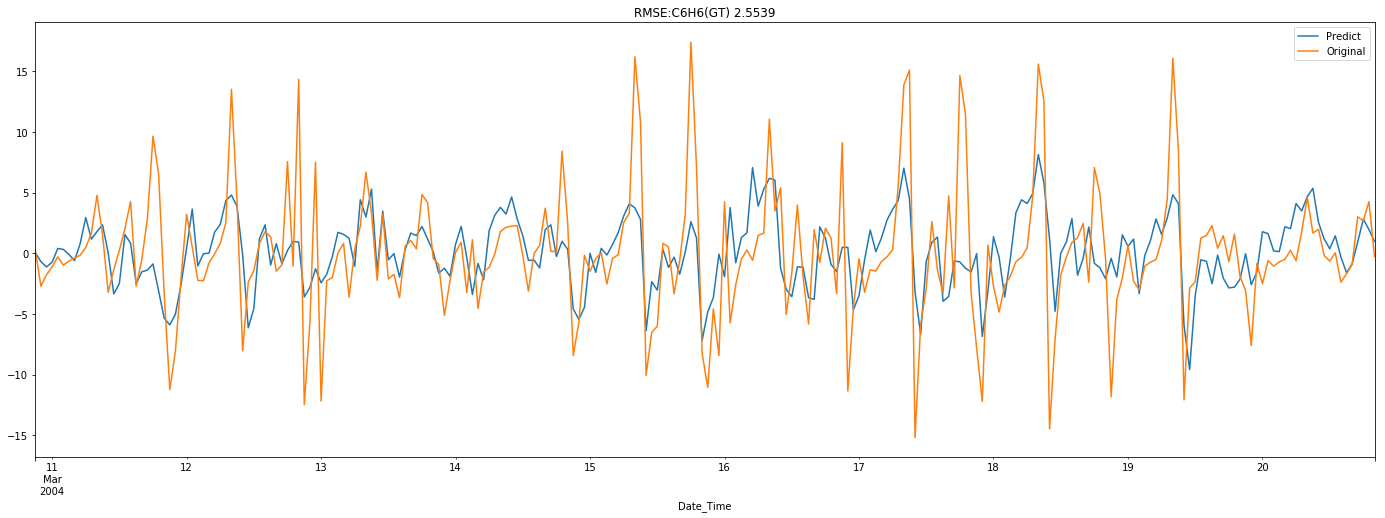

In [35]:
plt.figure(facecolor = 'white',figsize = (24,8))
prediction['C6H6(GT)'].plot(label='Predict')
diff_1_list['C6H6(GT)'].plot(label='Original')
plt.title('RMSE:C6H6(GT) %.4f'% np.sqrt(sum((diff_1_list['C6H6(GT)']-prediction['C6H6(GT)'])**2)/NewFrame.size))
plt.legend(loc='best')
plt.show()

Differential reduction

In [46]:
prediction = prediction.shift(1)
prediction.iloc[0] = first
x = 1
while(x<prediction.shape[0]):
    prediction.iloc[x] = prediction.iloc[x-1]+prediction.iloc[x]
    x+=1
print(prediction)

                       CO(GT)  PT08.S1(CO)   C6H6(GT)
2004-03-10 21:00:00  2.200000  1402.000000   8.997817
2004-03-10 22:00:00  2.211783  1403.779948   9.052826
2004-03-10 23:00:00  2.095948  1385.706276   8.356727
2004-03-11 00:00:00  1.906239  1364.883347   7.228277
2004-03-11 01:00:00  1.817860  1350.176456   6.499048
...                       ...          ...        ...
2004-03-20 16:00:00  6.450992  2303.551628  31.400073
2004-03-20 17:00:00  6.357925  2267.281825  30.515493
2004-03-20 18:00:00  6.533150  2272.856955  31.446331
2004-03-20 19:00:00  7.198975  2335.975733  34.264388
2004-03-20 20:00:00  7.846115  2404.004113  36.222180

[240 rows x 3 columns]


Plot result

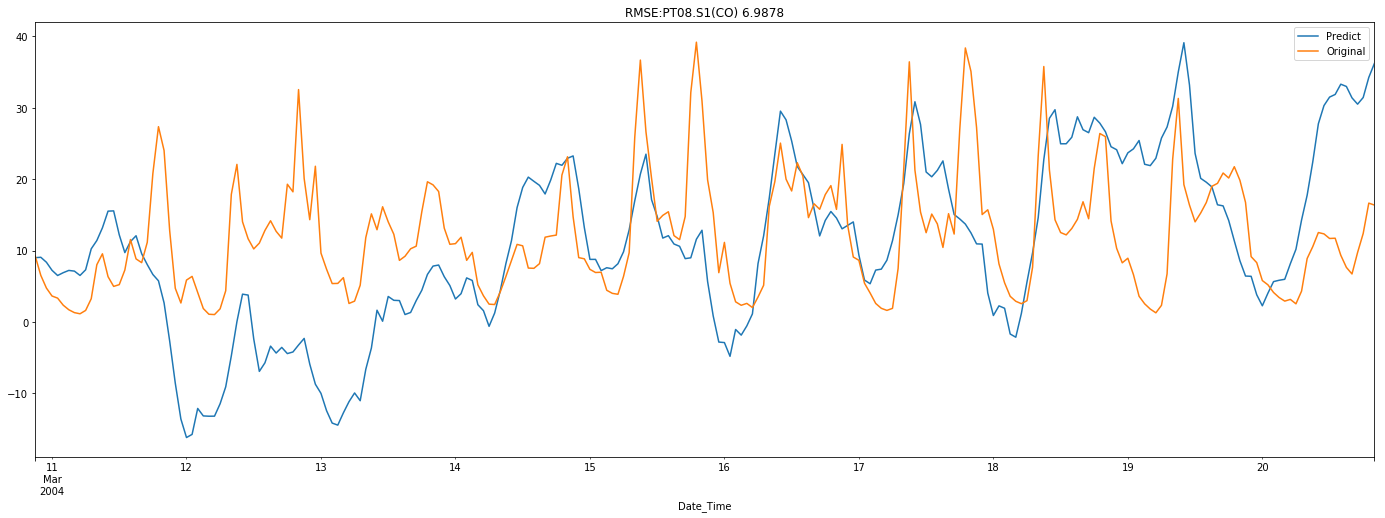

In [50]:
plt.figure(facecolor = 'white',figsize = (24,8))
prediction['C6H6(GT)'].plot(label='Predict')
NewFrame['C6H6(GT)'][1:].plot(label='Original')
plt.title('RMSE:PT08.S1(CO) %.4f'% np.sqrt(sum((prediction['C6H6(GT)']-NewFrame['C6H6(GT)'][1:])**2)/NewFrame.size))
plt.legend(loc='best')
plt.show()

# Generate prediction by VAR

In [12]:
VAR_Model = VAR(endog=NewFrame)
lag_order = VAR_Model.select_order()
print(lag_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        10.82       10.87   5.009e+04       10.84
1        8.334       8.516       4164.       8.407
2        8.042      8.360*       3109.      8.170*
3       8.020*       8.474      3043.*       8.204
4        8.022       8.613       3050.       8.261
5        8.055       8.781       3151.       8.348
6        8.055       8.917       3152.       8.403
7        8.098       9.096       3292.       8.501
8        8.090       9.225       3270.       8.548
9        8.113       9.384       3350.       8.626
10       8.135       9.542       3429.       8.703
11       8.088       9.632       3277.       8.711
12       8.063       9.743       3203.       8.741
13       8.045       9.861       3153.       8.778
14       8.060       10.01       3210.       8.848
15       8.084       10.17       3299.       8.927
-------------------------------

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [13]:
VAR_Prediction = VAR_Model.fit(3)
print(VAR_Prediction.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 27, Jan, 2020
Time:                     14:50:35
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    8.34357
Nobs:                     238.000    HQIC:                   8.08228
Log likelihood:          -1923.92    FPE:                    2713.61
AIC:                      7.90588    Det(Omega_mle):         2398.40
--------------------------------------------------------------------
Results for equation CO(GT)
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.787312         0.756390            1.041           0.298
L1.CO(GT)             -0.357996         0.263593           -1.358           0.174
L1.PT08.S1(CO)         0.005782         0.001210       

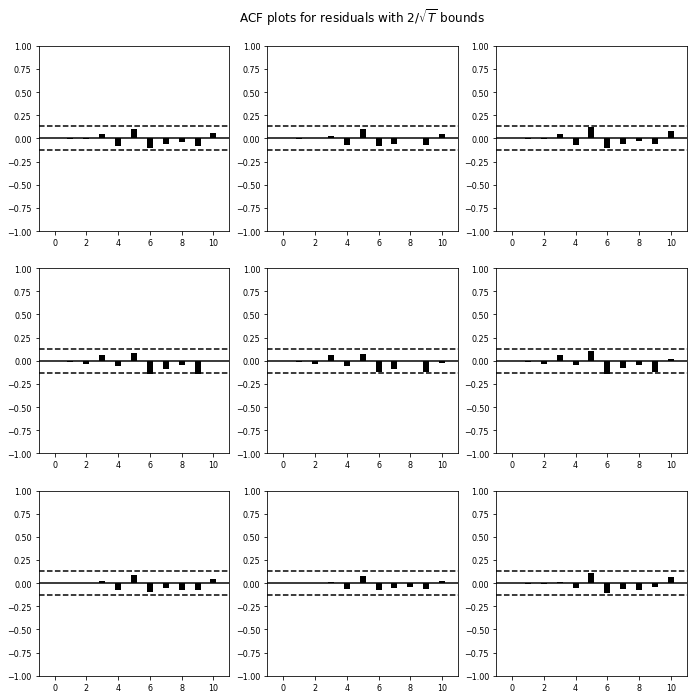

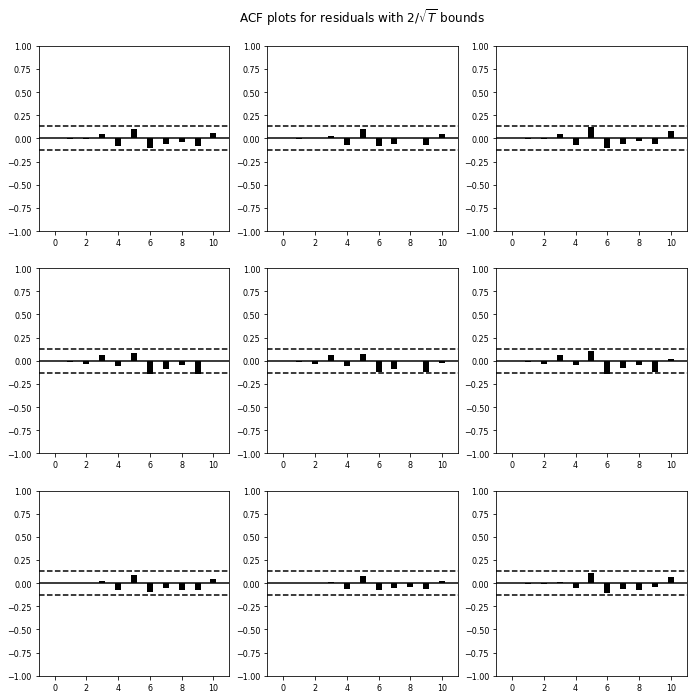

In [14]:
VAR_Prediction.plot_acorr(nlags=10, resid=True, linewidth=6)#滞后为10

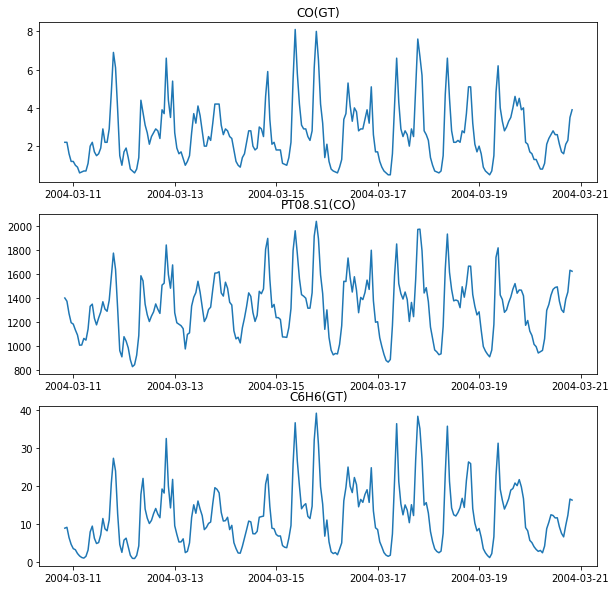

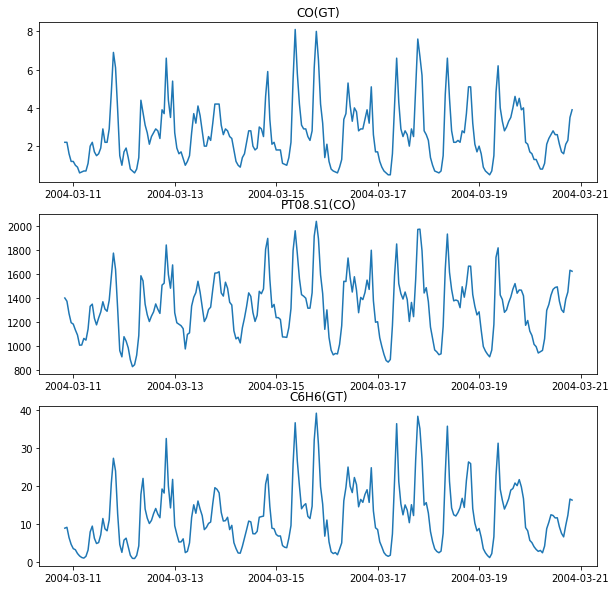

In [15]:
VAR_Prediction.plot()

In [16]:
lag_order = VAR_Prediction.k_ar
VAR_Prediction.forecast(NewFrame.values[-lag_order:],5)

array([[   3.15374488, 1501.57321037,   13.91753178],
       [   2.4851965 , 1374.19305456,   10.45505132],
       [   1.99646671, 1287.78269756,    7.91888922],
       [   1.7601578 , 1240.06100726,    6.92657011],
       [   1.77381238, 1229.05207973,    7.04356153]])